<a href="https://colab.research.google.com/github/Nantakxrn007/Data-Exploration-and-Preprocessing/blob/main/Test_star_schema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal: ทำ star schema โดยเชื่อม 2 database ในโค้ดเป็นการ test ว่าในการออกแบบถูกต้องหรือไม่

In [11]:
import pandas as pd
import requests
from sqlalchemy import create_engine

## เตรียม Database chinook, northwind

In [2]:
CHINOOK_url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite"
NORTHWIND_URL = "https://github.com/jpwhite3/northwind-SQLite3/raw/main/dist/northwind.db"

def pull(url,filename):
  with requests.get(url,stream=True) as r: #with เปิดแล้วปิดให้เลย
    r.raise_for_status() #เช็คว่าในเว็บถ้าขึ้น error 404 505 ไรนั้นอะให้แจ้งเตือนเลย
    with open(filename,'wb') as f: #wb binary เพราะว่า ตัวของ .db มันเป็น binary
      for chunk in r.iter_content(chunk_size=8192): #อ่านจากเว็บมา 8KB > เขียนลงไฟล์ > อ่านอีก 8KB > เขียนต่อ
        f.write(chunk)

pull(CHINOOK_url,'chinook.db')
pull(NORTHWIND_URL,'northwind.db')

## Query (ETL) 1) Extract and Transform

In [61]:
engine_chinook = create_engine("sqlite:///chinook.db")
engine_northwind = create_engine("sqlite:///northwind.db")

In [62]:
# Chinook
query_chinook = """
SELECT
    il.InvoiceLineId AS factid,
    i.InvoiceDate AS full_date,
    il.Quantity AS quantity,
    il.UnitPrice * il.Quantity AS income
FROM InvoiceLine il
JOIN Invoice i ON il.InvoiceId = i.InvoiceId
"""
df_chinook = pd.read_sql(query_chinook, engine_chinook)
df_chinook['discount'] = 0 # chinook don't have discount
df_chinook["business"] = "Chinook"

#datetime
#datetime
def standardize_date(date_str):
    # ถ้ามีเฉพาะวันที่ (ไม่มีเวลา)
    if len(date_str.split()) == 1:
        return date_str + " 00:00:00"
    return date_str

df_chinook['full_date'] = df_chinook['full_date'].apply(standardize_date)
df_chinook['full_date'] = pd.to_datetime(df_chinook['full_date'], format='%Y-%m-%d %H:%M:%S')


In [63]:
df_chinook

,factid,full_date,quantity,income,discount,business
0,1,2009-01-01,1,0.99,0,Chinook
1,2,2009-01-01,1,0.99,0,Chinook
2,3,2009-01-02,1,0.99,0,Chinook
3,4,2009-01-02,1,0.99,0,Chinook
4,5,2009-01-02,1,0.99,0,Chinook
...,...,...,...,...,...,...
2235,2236,2013-12-14,1,0.99,0,Chinook
2236,2237,2013-12-14,1,0.99,0,Chinook
2237,2238,2013-12-14,1,0.99,0,Chinook
2238,2239,2013-12-14,1,0.99,0,Chinook


In [64]:
# Northwind
query_northwind = """
SELECT
    od.OrderID || '-' || od.ProductID AS factid,
    o.OrderDate AS full_date,
    od.UnitPrice * od.Quantity AS income,
    od.Quantity AS quantity,
    od.Discount AS discount
FROM [Order Details] od
JOIN Orders o ON od.OrderID = o.OrderID
"""
df_northwind = pd.read_sql(query_northwind, engine_northwind)

df_northwind["business"] = "Northwind"

#datetime
def standardize_date(date_str):
    # ถ้ามีเฉพาะวันที่ (ไม่มีเวลา)
    if len(date_str.split()) == 1:
        return date_str + " 00:00:00"
    return date_str

df_northwind['full_date'] = df_northwind['full_date'].apply(standardize_date)
df_northwind['full_date'] = pd.to_datetime(df_northwind['full_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [65]:
df_northwind

,factid,full_date,income,quantity,discount,business
0,10248-11,2016-07-04 00:00:00,168.00,12,0.0,Northwind
1,10248-42,2016-07-04 00:00:00,98.00,10,0.0,Northwind
2,10248-72,2016-07-04 00:00:00,174.00,5,0.0,Northwind
3,10249-14,2016-07-05 00:00:00,167.40,9,0.0,Northwind
4,10249-51,2016-07-05 00:00:00,1696.00,40,0.0,Northwind
...,...,...,...,...,...,...
609278,26529-10,2023-01-10 05:40:51,806.00,26,0.0,Northwind
609279,26529-46,2023-01-10 05:40:51,216.00,18,0.0,Northwind
609280,26529-26,2023-01-10 05:40:51,93.69,3,0.0,Northwind
609281,26529-27,2023-01-10 05:40:51,1053.60,24,0.0,Northwind


In [66]:
df_fact = pd.concat([df_chinook, df_northwind], ignore_index=True)
df_fact

,factid,full_date,quantity,income,discount,business
0,1,2009-01-01 00:00:00,1,0.99,0.0,Chinook
1,2,2009-01-01 00:00:00,1,0.99,0.0,Chinook
2,3,2009-01-02 00:00:00,1,0.99,0.0,Chinook
3,4,2009-01-02 00:00:00,1,0.99,0.0,Chinook
4,5,2009-01-02 00:00:00,1,0.99,0.0,Chinook
...,...,...,...,...,...,...
611518,26529-10,2023-01-10 05:40:51,26,806.00,0.0,Northwind
611519,26529-46,2023-01-10 05:40:51,18,216.00,0.0,Northwind
611520,26529-26,2023-01-10 05:40:51,3,93.69,0.0,Northwind
611521,26529-27,2023-01-10 05:40:51,24,1053.60,0.0,Northwind


In [68]:
df_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611523 entries, 0 to 611522
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   factid     611523 non-null  object        
 1   full_date  611523 non-null  datetime64[ns]
 2   quantity   611523 non-null  int64         
 3   income     611523 non-null  float64       
 4   discount   611523 non-null  float64       
 5   business   611523 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 28.0+ MB


## Create Dimensions

In [69]:
dim_date = df_fact[['full_date']].drop_duplicates().reset_index(drop=True) #ตรงนี้ระวัง แต่ว่าใน Dimdate เราไม่มีวันซ้ำกันอยู่แล้ว มันเชื่อมกับ key fact หลักยังไงก็แยกออกแล้วข้อมูลไม่หาย
dim_date['Dimdate_id'] = dim_date.index + 1
dim_date['year'] = dim_date['full_date'].dt.year
dim_date['month'] = dim_date['full_date'].dt.month
dim_date['day'] = dim_date['full_date'].dt.day
dim_date['day_of_week'] = df_fact['full_date'].dt.day_name()

In [70]:
dim_date

,full_date,Dimdate_id,year,month,day,day_of_week
0,2009-01-01 00:00:00,1,2009,1,1,Thursday
1,2009-01-02 00:00:00,2,2009,1,2,Thursday
2,2009-01-03 00:00:00,3,2009,1,3,Friday
3,2009-01-06 00:00:00,4,2009,1,6,Friday
4,2009-01-11 00:00:00,5,2009,1,11,Friday
...,...,...,...,...,...,...
16281,2012-12-26 04:58:22,16282,2012,12,26,Saturday
16282,2022-08-05 06:33:39,16283,2022,8,5,Saturday
16283,2022-02-09 08:20:12,16284,2022,2,9,Saturday
16284,2020-04-27 23:05:30,16285,2020,4,27,Saturday


In [71]:
dim_business = pd.DataFrame({'Dimbusiness_id':[1,2], 'name':['Chinook','Northwind']})
df_fact['Dimbusiness_id'] = df_fact['business'].map({'Chinook':1,'Northwind':2})

In [72]:
dim_business

,Dimbusiness_id,name
0,1,Chinook
1,2,Northwind


In [73]:
df_fact = df_fact.merge(dim_date[['Dimdate_id','full_date']], on='full_date', how='left') #ถ้าเจอ match ใน df_fact,dim_date เอา Dimdate_id มาใส่
df_fact #คือการ map Dimdate_id โดยที่ถ้า fulldate ของทั้ง 2 table ตรงกันจะ map Dimdate_id

,factid,full_date,quantity,income,discount,business,Dimbusiness_id,Dimdate_id
0,1,2009-01-01 00:00:00,1,0.99,0.0,Chinook,1,1
1,2,2009-01-01 00:00:00,1,0.99,0.0,Chinook,1,1
2,3,2009-01-02 00:00:00,1,0.99,0.0,Chinook,1,2
3,4,2009-01-02 00:00:00,1,0.99,0.0,Chinook,1,2
4,5,2009-01-02 00:00:00,1,0.99,0.0,Chinook,1,2
...,...,...,...,...,...,...,...,...
611518,26529-10,2023-01-10 05:40:51,26,806.00,0.0,Northwind,2,16286
611519,26529-46,2023-01-10 05:40:51,18,216.00,0.0,Northwind,2,16286
611520,26529-26,2023-01-10 05:40:51,3,93.69,0.0,Northwind,2,16286
611521,26529-27,2023-01-10 05:40:51,24,1053.60,0.0,Northwind,2,16286


In [74]:
df_fact = df_fact.drop(columns=['full_date','business'])

In [75]:
df_fact

,factid,quantity,income,discount,Dimbusiness_id,Dimdate_id
0,1,1,0.99,0.0,1,1
1,2,1,0.99,0.0,1,1
2,3,1,0.99,0.0,1,2
3,4,1,0.99,0.0,1,2
4,5,1,0.99,0.0,1,2
...,...,...,...,...,...,...
611518,26529-10,26,806.00,0.0,2,16286
611519,26529-46,18,216.00,0.0,2,16286
611520,26529-26,3,93.69,0.0,2,16286
611521,26529-27,24,1053.60,0.0,2,16286


## Load ลง star.db

In [76]:
import sqlite3

In [4]:
# new star schema db
star_conn = sqlite3.connect("star.db")
cur = star_conn.cursor()

# create schema
cur.executescript("""
CREATE TABLE Dimdate_table (
  Dimdate_id INTEGER PRIMARY KEY,
  full_date TEXT,
  year INT,
  month INT,
  day INT,
  day_of_week TEXT
);

CREATE TABLE Dimbusiness_table (
  Dimbusiness_id INTEGER PRIMARY KEY,
  name TEXT
);

CREATE TABLE Fact_table (
  factid INTEGER PRIMARY KEY AUTOINCREMENT,
  income FLOAT,
  expense FLOAT,
  quantity INT,
  discount FLOAT,
  Dimdate_id INT,
  Dimbusiness_id INT,
  FOREIGN KEY (Dimdate_id) REFERENCES Dimdate_table(Dimdate_id),
  FOREIGN KEY (Dimbusiness_id) REFERENCES Dimbusiness_table(Dimbusiness_id)
);
""")
star_conn.commit()


In [78]:
star_conn = create_engine("sqlite:///star.db")

# Save Dimension Tables
dim_date.to_sql("Dimdate_table", star_conn, if_exists="replace", index=False)
dim_business.to_sql("Dimbusiness_table", star_conn, if_exists="replace", index=False)

# Save Fact Table
df_fact[['factid','income','quantity','discount','Dimdate_id','Dimbusiness_id']].to_sql(
    "Fact_table", star_conn, if_exists="replace", index=False
)


611523

## Test

In [79]:
test_df = pd.read_sql("""
SELECT *
FROM Fact_table f
""", star_conn)

test_df

,factid,income,quantity,discount,Dimdate_id,Dimbusiness_id
0,1,0.99,1,0.0,1,1
1,2,0.99,1,0.0,1,1
2,3,0.99,1,0.0,2,1
3,4,0.99,1,0.0,2,1
4,5,0.99,1,0.0,2,1
...,...,...,...,...,...,...
611518,26529-10,806.00,26,0.0,16286,2
611519,26529-46,216.00,18,0.0,16286,2
611520,26529-26,93.69,3,0.0,16286,2
611521,26529-27,1053.60,24,0.0,16286,2


homework  
# business questions
1. What is monthly income for each business unit?
2. Estimate monthly expense for each business unit? #มันไม่มีตัดออก
3. What is the sale value pattern from Monday to Sunday?

In [84]:
import matplotlib.pyplot as plt

In [82]:
df = pd.read_sql("""
SELECT f.income, f.quantity, f.discount,
       d.year, d.month, d.day_of_week, b.name as business
FROM Fact_table f
JOIN Dimdate_table d ON f.Dimdate_id = d.Dimdate_id
JOIN Dimbusiness_table b ON f.Dimbusiness_id = b.Dimbusiness_id
""", star_conn)
df

,income,quantity,discount,year,month,day_of_week,business
0,0.99,1,0.0,2009,1,Thursday,Chinook
1,0.99,1,0.0,2009,1,Thursday,Chinook
2,0.99,1,0.0,2009,1,Thursday,Chinook
3,0.99,1,0.0,2009,1,Thursday,Chinook
4,0.99,1,0.0,2009,1,Thursday,Chinook
...,...,...,...,...,...,...,...
611518,806.00,26,0.0,2023,1,Saturday,Northwind
611519,216.00,18,0.0,2023,1,Saturday,Northwind
611520,93.69,3,0.0,2023,1,Saturday,Northwind
611521,1053.60,24,0.0,2023,1,Saturday,Northwind


In [107]:
df_chinook_test = df.query('business == "Chinook"')
df_northwind_test = df.query('business == "Northwind"')


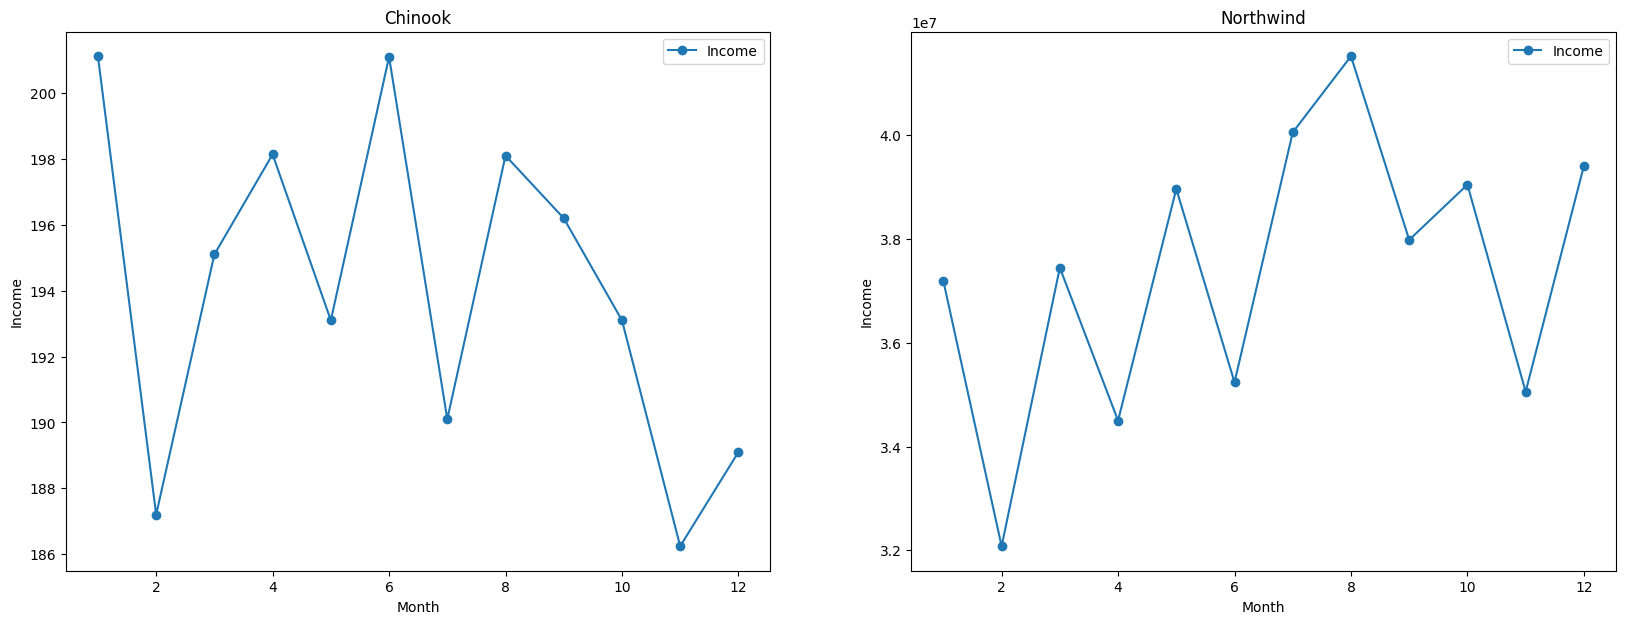

In [117]:

plt.figure(figsize=(20,7))
plt.subplot(121)
plt.title('Chinook')
chinook_monthly = df_chinook_test[['income','month']].groupby('month').sum().reset_index()
plt.plot(chinook_monthly['month'], chinook_monthly['income'], marker='o', label='Income')
plt.xlabel('Month')
plt.ylabel('Income')
plt.legend()

plt.subplot(122)
plt.title('Northwind')
northwind_monthly = df_northwind_test[['income','month']].groupby('month').sum().reset_index()
plt.plot(northwind_monthly['month'], northwind_monthly['income'], marker='o', label='Income')
plt.xlabel('Month')
plt.ylabel('Income')
plt.legend()

plt.show()


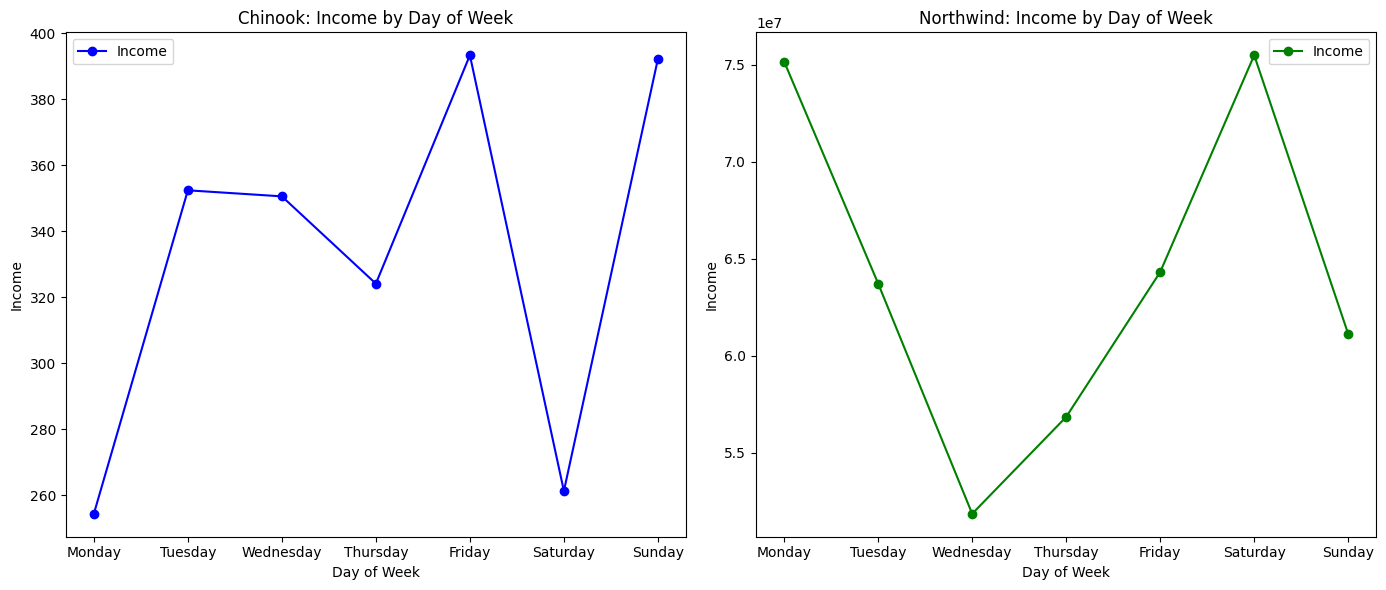

In [119]:

plt.figure(figsize=(14,6))

plt.subplot(121)
plt.title('Chinook: Income by Day of Week')
chinook_weekly = df_chinook_test.groupby('day_of_week')['income'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.plot(chinook_weekly.index, chinook_weekly.values, marker='o', color='blue', label='Income')
plt.xlabel('Day of Week')
plt.ylabel('Income')
plt.legend()

plt.subplot(122)
plt.title('Northwind: Income by Day of Week')
northwind_weekly = df_northwind_test.groupby('day_of_week')['income'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.plot(northwind_weekly.index, northwind_weekly.values, marker='o', color='green', label='Income')
plt.xlabel('Day of Week')
plt.ylabel('Income')
plt.legend()

plt.tight_layout()
plt.show()